# NAIRU Model

Modelling the non-accelerating inflation rate of unemployment (NAIRU) for the Australian economy, using a variant of the RBA's approach.

#### The broad approach

We are using a Bayesian approach to solve a system of equations:

* The NAIRU state-space equation:

$$ U^{*}_{t} = U^{*}_{t-1} + \epsilon_{N} $$

* The price-inflation equation:

$$ \pi_{t} = \alpha_{pi}\Delta4\rho^{m}_{t-1} + \sum_{k=1}^{2}\beta_{pi(k)}\pi_{t-k} + 
   \gamma_{pi}\frac{(U_t - U^*_t)}{U_t} + \delta_{pi}\pi^{e}_{t} + 
   \xi_{pi}\Xi^2_{t-2} + \theta_{pi}\omega_t + \epsilon_{pi}$$

    The level of inflation equals:
    * a fraction of lagged import price growth
    * plus a weighted sum of the previous two quarters' inflation
    * plus a Phillips curve effect (negative when unemployment is above the NAIRU)
    * plus a fraction of the level of inflation expectations
    * plus a COVID supply disruption effect (only active 2020-2023)
    * plus an oil price shock effect
    * plus random error

* The wage-growth equation:

$$ \Delta ulc_t = \beta_{wg}\sum_{k=1}^2\pi_{t-k} + \gamma_{wg}\frac{(U_t - U^*_t)}{U_t} + 
   \delta_{wg}\pi^{e}_{t} + \lambda_{wg}\frac{(U_{t-1} - U_{t-2})}{U_t} + \epsilon_{wg}$$

    The level of unit labour cost growth equals:
    * a weighted sum of the previous two quarters' inflation
    * plus a Phillips curve effect (negative when unemployment is above the NAIRU)
    * plus a fraction of the level of inflation expectations
    * plus a momentum effect from the change in unemployment
    * plus random error



Where:

 * $U^{*}$ is the NAIRU (expressed as a percentage of the labour force)
 * $U$ is the unemployment rate (expressed as a percentage of the labour force)
 * $\rho$ is the quarterly percentage change in the trimmed mean CPI (inflation level)
 * $\Delta4\rho^{m}$ is the four quarter percentage change in the import price index
 * $\rho^{e}$ is the long-run quarterly inflation expectation (level)
 * $\Xi$ is the Global Supply Chain Price Index (proxy for COVID-19 effects)
 * $\omega$ is the quarterly change in AUD oil prices
 * $\Delta ulc$ is the quarterly change in percentage terms for the unit labour costs
 * $\epsilon$ is the error term in the various equations, which is normally distributed around zero

 Note:
 
  * Only using two historical inflation terms (and not three) in the price inflation equation. The RBA uses three. This is because the beta3_pi term was not significantly different to zero.
  * Similarly, the $\lambda_{pi}\frac{(U_{t-1} - U_{t-2})}{U_t}$ term was not used in the price inflation equation, as it did not produce a statistically significant $\lambda_{pi}$ parameter.
  * The use of the global supply chain price index during the COVID-19 period (2020Q1 to 2023Q2) is an addition to the RBA model (hat tip to Zac Gross for first exploring this approach).


#### Acknowledgements

This work has drawn on ideas and approaches in the following:

Most useful:

 * https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

 * https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

 * https://github.com/MacroDave/NAIRU

 * https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

Also useful:

 * https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

 * https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

 * https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
# system imports
from typing import cast

In [2]:
# Analtic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm  # type: ignore[import-untyped]
import matplotlib.pyplot as plt
from IPython.display import display
from readabs import read_abs_series, read_rba_table

In [3]:
# local imports
import mgplot as mg 
import henderson
from abs_structured_capture import ReqsDict, ReqsTuple, get_abs_data, load_series

In [4]:
# Plotting set-up
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
mg.set_chart_dir(CHART_DIR)
mg.clear_chart_dir()

RFOOTER = "ABS: 1364.0.15.003"

# display charts in this notebook
SHOW = False

## Data capture

#### Utility

In [5]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of
    the three months in each quarter. Ignore quarters with less than
    three months data. Drop NA items."""

    return (
        data.groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(["mean", "count"])
        .apply(lambda x: x["mean"] if x["count"] == 3 else np.nan, axis=1)
        .dropna()
    )

In [6]:
# plot the 2.5% annual inflation target in quarterly terms

QUARTERLY_TARGET = {
    "axhline": {
        "y": (pow(1.025, 0.25) - 1) * 100,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "Quarterly growth consistent with 2.5% annual inflation",
    }
}

QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}

ANNUAL_RANGE = {
    "axhspan": {
        "ymin": 2,
        "ymax": 3,
        "color": "#dddddd",
        "label": "2-3% annual inflation target",
        "zorder": -1,
    }
}

#### Unemployment rate

In [7]:
def get_unemployment() -> tuple[pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, and the change in the UE rate."""

    wanted: ReqsDict = {
        # ReqsTupleL cat, table, did, stype, unit, seek_yr_growth, calc_growth, zip_file
        "Labor Force": 
            ReqsTuple("1364.0.15.003", "1364015003", "Total labour force ;", "S", "", False, False, ""),
        "Unemployed":
            ReqsTuple("1364.0.15.003", "1364015003", "Total unemployed ;", "S", "", False, False, ""),
    }
    data = get_abs_data(wanted)
    u = (data["Unemployed"] / data["Labor Force"]) * 100
    n = 1
    us = u.rolling(window=n, min_periods=n, center=True).mean()
    u = us.where(us.notna(), other=u)

    # calculate the change in the UE rate as a proportion of the UE rate
    delta_u = u.diff(1)
    delta_u_1 = delta_u.shift(1)

    # Plot the data
    common_format = {
        "lfooter": "Australia. Seasonally adjusted series. Quarterly data. ",
        "rfooter": RFOOTER,
        "show": SHOW,
        "y0": True,
    }

    mg.line_plot_finalise(
        u,
        title="Unemployment rate",
        ylabel="Per cent of Labour Force",
        **common_format,
    )

    mg.line_plot_finalise(
        delta_u,
        title="Change in the unemployment rate (ΔU)",
        ylabel="Q/Q Percentage points",
        **common_format,
    )

    # return the values
    return u, delta_u, delta_u_1


U, ΔU, ΔU_1 = get_unemployment()

#### Inflation

In [8]:
def get_inflation(measure="TM") -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get trimmed mean inflation as a measure of core inflation.
    Returns: A tuple of four series - the core inflation rate, and that
    rate lagged by 1, 2 and 3 quarters."""

    # -- will need a rework when the CPI is updated in late January 2026 --
    tm = "Percentage Change from Previous Period ;  Trimmed Mean ;  Australia ;"
    headline = "Percentage Change from Previous Period ;  All groups CPI, seasonally adjusted ;  Australia ;"
    old_cpi = "./ABS-Data/Qrtly-CPI-Time-series-spreadsheets-all.zip"
    wanted = {
    "Trimmed Mean" :
        ReqsTuple("", "640106", tm, "S", "", False, False, old_cpi),
    }
    data = get_abs_data(wanted)
    n = 1  # must be odd - 1 indicates no smoothing, 3 and 5 are the other options for more smoothing
    smooth_trim = data["Trimmed Mean"].rolling(window=n, min_periods=n, center=True).mean()
    inflation = smooth_trim.where(smooth_trim.notna(), other=data["Trimmed Mean"])

    mg.line_plot_finalise(
        inflation,
        title="Q/Q Inflation",
        ylabel="Q/Q Percentage change",
        lfooter="Australia. Seasonally adjusted series. Quarterly data. ",
        rfooter="ABS",
        show=SHOW,
        y0=True,
        tag="qtr",
        legend=True,
        axhspan=QUARTERLY_RANGE["axhspan"],
    )

    pi = inflation
    pi_1 = pi.shift(periods=1).dropna() 
    pi_2 = pi.shift(periods=2).dropna()
    pi_3 = pi.shift(periods=3).dropna()

    return pi, pi_1, pi_2, pi_3


π, π_1, π_2, π_3 = get_inflation()

#### Inflation expectations

Uses RBA G3 inflation expectations survey data (business expectations) where available, 
otherwise falls back to 10-year government bond yields from RBA as proxy.

Both are converted from annual to quarterly using: `(1+value/100)^(1/4)-1)*100`

In [9]:
def annual_to_quarterly_expectation(annual_rate: pd.Series) -> pd.Series:
    """Convert annual inflation expectations to quarterly.
    Formula: ((1 + annual_rate/100)^(1/4) - 1) * 100"""
    return ((1 + annual_rate / 100) ** (1/4) - 1) * 100


def get_bond_yield_expectations() -> pd.Series:
    """Get 10-year government bond yields from RBA as proxy for inflation expectations.
    Returns quarterly inflation expectations (converted from annual)."""
    
    # Get historical 10-year government bond yields directly from RBA
    hist_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f02histhist.xls"
    hist_bonds = pd.read_excel(hist_url, sheet_name="Data", header=10, index_col=0)
    hist_bonds.index = pd.PeriodIndex(hist_bonds.index, freq="Q")
    hist_bonds = hist_bonds.groupby(hist_bonds.index).last()
    hist_yield = hist_bonds["FCMYGBAG10"].dropna()
    
    # Get current 10-year government bond yields from RBA F2.1
    bonds, _meta = read_rba_table("F2.1")
    bonds.index = pd.PeriodIndex(bonds.index, freq="Q")
    bonds = bonds.groupby(bonds.index).last()
    current_yield = bonds["FCMYGBAG10"].dropna()
    
    # Merge historical and current, preferring current for overlapping periods
    bond_yield = pd.concat([hist_yield, current_yield])
    bond_yield = bond_yield[~bond_yield.index.duplicated(keep='last')]
    bond_yield = bond_yield.sort_index()
    
    # Convert from annual to quarterly
    return annual_to_quarterly_expectation(bond_yield)


def get_g3_expectations() -> pd.Series:
    """Get inflation expectations from RBA G3 table (business expectations).
    Returns quarterly inflation expectations (converted from annual)."""
    
    g3, _meta = read_rba_table("G3")
    g3.index = pd.PeriodIndex(g3.index, freq="Q")
    
    # Use business inflation expectations (GBUSEXP) - starts 1989Q3
    # This is annualised 3-month ahead business expectations
    bus_exp = g3["GBUSEXP"].dropna()
    
    # Convert from annual to quarterly
    return annual_to_quarterly_expectation(bus_exp)


def get_inflation_expectations() -> pd.Series:
    """Get inflation expectations - uses G3 survey data where available,
    otherwise falls back to bond yields.
    Returns LEVEL of quarterly inflation expectations."""
    
    # Get both sources
    bond_exp = get_bond_yield_expectations()
    g3_exp = get_g3_expectations()
    
    # Use G3 where available, otherwise use bond yields
    # G3 business expectations start from 1989Q3
    quarterly_exp = bond_exp.copy()
    quarterly_exp.update(g3_exp)  # G3 values overwrite bond values where they exist
    quarterly_exp = quarterly_exp.sort_index()
    
    # Plot the combined expectations (level)
    mg.line_plot_finalise(
        quarterly_exp,
        title="Quarterly Inflation Expectations (level)",
        ylabel="Quarterly rate (%)",
        lfooter="Australia. G3 survey data where available, bond yields otherwise.",
        rfooter="RBA",
        show=SHOW,
        y0=True,
        tag="level",
        legend=True,
    )
    
    # Also plot comparison of the two sources
    mg.line_plot_finalise(
        pd.DataFrame({
            "Bond yield expectations": bond_exp,
            "G3 survey expectations": g3_exp,
        }),
        title="Quarterly Inflation Expectations by Source",
        ylabel="Quarterly rate (%)",
        lfooter="Australia. Annual rates converted to quarterly.",
        rfooter="RBA",
        show=SHOW,
        y0=True,
        tag="comparison",
        legend=True,
        axhspan=QUARTERLY_RANGE["axhspan"],
    )
    
    return quarterly_exp.astype(float)


πe = get_inflation_expectations()

#### Import prices (from ABS 6457)

In [10]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade, _trade_meta = read_abs_series(cat="6457.0", series_id="A2298279F")
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    dlip_1 = delta4_log_import_prices.shift(periods=1).dropna()
    dlip_2 = delta4_log_import_prices.shift(periods=2).dropna()

    # plot the data
    ax = dlip_1.plot(lw=2)
    mg.finalise_plot(
        ax,
        title="Lagged change in import prices (Δ4ρm_1)",
        ylabel="diff(log(Import Price Index))*100",
        y0=True,
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 6457",
        show=SHOW,
    )

    return dlip_1, dlip_2


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()

Table 64570DO001 has no 'Index' sheet.
Table 64570DO002 has no 'Index' sheet.
Table 64570DO003 has no 'Index' sheet.


#### Unit labour costs

In [11]:
def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts, _nat_accounts_meta = read_abs_series(
        cat="5206.0", series_id=["A2304402X", "A2302915V"]
    )
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    # plot the data
    term = 13
    trend = henderson.hma(delta_ulc, term)
    mg.line_plot_finalise(
        pd.DataFrame(
            {
                "Qrtly unit labour costs growth": delta_ulc,
                f"{term}-term Henderson moving average": trend,
            }
        ),
        title="Qrtly unit labour costs growth",
        ylabel="diff(log(ULC))*100",
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 5206",
        width=[1.5, 2.5],
        y0=True,
        show=SHOW,
    )
    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during the COVID-19 period

This is an addition to the RBA model. The Global Supply Chain Price Index is used for a limited time period to approximate the related impacts of COVID-19 and the start of the Ukraine war on prices. 

In [12]:
def get_gscpi() -> tuple[pd.Series, pd.Series]:
    """Global Supply Chain Price Index. Usefulk for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening and the Ukraine war).
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls",
        sheet_name="GSCPI Monthly Data",
        index_col=0,
        parse_dates=True,
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    quarter = pd.Timestamp.today().to_period('Q')
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=quarter-1, freq="Q"))
    mask = (dummy.index >= "2020Q1") & (dummy.index <= "2023Q2")
    dummy[mask] = 0  # - key dates for the COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    mg.line_plot_finalise(
        gscpi,
        title="Global supply constraints",
        ylabel="Index",
        lfooter="Quarterly data. ",
        rfooter="Source: New York Fed",
        width=2,
        y0=True,
        show=SHOW,
    )
    mg.line_plot_finalise(
        pd.DataFrame({"gscpi_1": gscpi_1, "gscpi_2": gscpi_2}),
        title="Global supply constraints - lagged and constrained",
        ylabel="Index",
        lfooter="Quarterly data. ",
        width=2,
        show=SHOW,
    )

    return gscpi_1, gscpi_2


ξ_1, ξ_2 = get_gscpi()

#### Oil price shocks

Uses World Bank commodity price data for crude oil, converted to AUD using RBA exchange rates. Captures energy supply shocks throughout the full sample period.

In [13]:
def get_oil_shock() -> pd.Series:
    """Get oil price shocks for the full sample period.
    Uses World Bank crude oil prices (average of Brent, Dubai, WTI) converted to AUD.
    Returns quarterly log change in AUD oil prices."""
    
    # Get USD oil prices from World Bank Pink Sheet - Historical Data
    url = (
        "https://thedocs.worldbank.org/en/doc/" +
        "18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx"
    )
    commodities: pd.DataFrame = pd.read_excel(
        url, sheet_name="Monthly Prices", header=6, na_values=['N/A', 'missing', '-', '…'], index_col=0
    )

    oil_monthly: pd.Series = (
        commodities[['CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'CRUDE_WTI']]
        .astype(float)
        .mean(axis=1)
    )
    oil_monthly.index = oil_monthly.index.str.replace('M', '-')
    oil_monthly.index = pd.PeriodIndex(oil_monthly.index, freq="Q")

    oil_quarterly: pd.Series = oil_monthly.groupby(oil_monthly.index).mean()

    hist_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist-1969-2009.xls"
    now_url = "https://www.rba.gov.au/statistics/tables/xls-hist/f11hist.xls"

    container = []
    for url in [hist_url, now_url]:
        table = pd.read_excel(url, sheet_name="Data", header=10, index_col=0)
        series: pd.Series = table["FXRUSD"].dropna()
        series.index = pd.PeriodIndex(series.index, freq="Q")
        series = series.groupby(series.index).mean()
        container.append(series)

    aud_usd = pd.concat(container)
    
    # Convert oil to AUD: USD_price / (AUD/USD) = AUD_price
    oil_aud: pd.Series = oil_quarterly.div(aud_usd).dropna()

    mg.line_plot_finalise(
        oil_aud,
        title="Crude oil prices in AUD",
        ylabel="AUD per barrel",
        lfooter="Quarterly data. World Bank crude oil prices converted to AUD.",
        rfooter="World Bank, RBA",
        width=2,
        y0=True,
        show=SHOW,
    )


    # Calculate quarterly log change (percentage change)
    log_oil_aud = oil_aud.apply(np.log)
    delta_log_oil = (log_oil_aud.diff(1) * 100).dropna()
    
    mg.line_plot_finalise(
        delta_log_oil,
        title="Quarterly change in AUD oil prices",
        ylabel="percent change (log difference)",
        lfooter="Quarterly data. World Bank crude oil prices converted to AUD.",
        rfooter="World Bank, RBA",
        width=2,
        y0=True,
        show=SHOW,
    )
    
    return delta_log_oil


oil_shock = get_oil_shock()

## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [14]:
def build_obs() -> tuple[dict[str, np.ndarray], pd.PeriodIndex]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Beacuse the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame(
        {
            # Note: in the process of model development, not all of the data
            # collected here will be used in the model. However, it is retained
            # as it may be useful in the future.
            "π": π,      # core inflation level
            "π_1": π_1,  # lagged core inflation level
            "π_2": π_2,
            "π_3": π_3,
            "πe": πe,    # inflation expectations LEVEL (not change)
            # unemployment
            "U": U,  # unemployment rate
            "ΔU": ΔU,  # change in UE rate
            "ΔU_1": ΔU_1,  # lagged change in UE rate
            "ΔU_1_over_U": ΔU_1 / U,  # UE rate change as proportion of UE rate
            # other
            "Δ4ρm_1": Δ4ρm_1,  # annual change in import prices,
            "Δ4ρm_2": Δ4ρm_2,  # annual change in import prices, lagged 1 period
            "Δulc": Δulc,  # unit labour costs growth
            "ξ_1": ξ_1,  # lagged supply shock
            "ξ_2": ξ_2,  # lagged supply shock
            "oil_shock": oil_shock,  # oil price shocks (full sample)
        }
    )

    print(observed.tail())
    observed = observed.dropna(
        how="any"
    )  # Note ulc comes from Nat Accounts, which is delayed data
    print(
        f"Number of periods: {len(observed)}; from: "
        f"{observed.index[0]}, concluding: {observed.index[-1]}"
    )

    return {str(x): y.to_numpy() for x, y in observed.items()}, cast(
        pd.PeriodIndex, observed.index
    )


obs, obs_index = build_obs()

          π  π_1  π_2  π_3        πe         U        ΔU      ΔU_1  \
2024Q4  0.6  0.8  0.9  1.0  0.498756  3.921698 -0.188890  0.134418   
2025Q1  0.7  0.6  0.8  0.9  0.424786  4.051383  0.129685 -0.188890   
2025Q2  0.7  0.7  0.6  0.8  0.611861  4.078698  0.027315  0.129685   
2025Q3  1.0  0.7  0.7  0.6  0.409972       NaN       NaN       NaN   
2025Q4  NaN  NaN  NaN  NaN  1.042097       NaN       NaN       NaN   

        ΔU_1_over_U    Δ4ρm_1    Δ4ρm_2      Δulc  ξ_1  ξ_2  oil_shock  
2024Q4     0.034276  1.133371  0.907722  1.469783  0.0  0.0  -2.050488  
2025Q1    -0.046624  0.446097  1.133371  1.320522  0.0  0.0   4.934614  
2025Q2     0.031796  3.205642  0.446097  0.548440  0.0  0.0 -15.432524  
2025Q3          NaN  2.967577  3.205642       NaN  0.0  0.0   1.220240  
2025Q4          NaN       NaN       NaN       NaN  NaN  NaN  -6.855255  
Number of periods: 163; from: 1984Q4, concluding: 2025Q2


## Bayesian model

#### The PyMC model

**Price Inflation Equation:**

| Term | Coefficient | Description |
|------|-------------|-------------|
| $\Delta4\rho^{m}_{t-1}$ | `alpha_pi` | Lagged annual change in import prices - captures imported inflation pass-through |
| $\pi_{t-1}$ | `beta1_pi` | First lag of quarterly inflation level - inflation persistence |
| $\pi_{t-2}$ | `beta2_pi` | Second lag of quarterly inflation level - inflation persistence |
| $(U_t - U^*_t)/U_t$ | `gamma_pi` | Unemployment gap as proportion of unemployment rate - Phillips curve effect |
| $\pi^{e}_{t}$ | `delta_pi` | Level of inflation expectations - forward-looking expectations channel |
| $\Xi^2_{t-2} \cdot sign(\Xi_{t-2})$ | `xi_2sq_pi` | COVID supply chain disruptions (2020Q1-2023Q2 only) |
| $oil\_shock_t$ | `theta_pi` | Quarterly change in AUD oil prices - energy price pass-through |
| $\epsilon_{pi}$ | `epsilon_pi` | Error term standard deviation |

**Wage Growth Equation:**

| Term | Coefficient | Description |
|------|-------------|-------------|
| $\pi_{t-1} + \pi_{t-2}$ | `beta_wg` | Sum of lagged inflation levels - wage-price catch-up |
| $(U_t - U^*_t)/U_t$ | `gamma_wg` | Unemployment gap - labour market slack effect on wages |
| $\pi^{e}_{t}$ | `delta_wg` | Level of inflation expectations - wage bargaining expectations |
| $(U_{t-1} - U_{t-2})/U_t$ | `lambda_wg` | Change in unemployment rate - momentum effect on wage dynamics |
| $\epsilon_{wg}$ | `epsilon_wg` | Error term standard deviation |

**Key interpretation:**
- Negative `gamma` coefficients indicate that when unemployment is above the NAIRU (positive gap), inflation/wages fall
- The unemployment gap is normalised by the unemployment rate to make the effect proportional
- Fixed `beta1_pi=0.6` and `beta2_pi=0.2` prevent near-unit-root behaviour in inflation persistence
- Fixed `nairu_innovation=0.25` allows NAIRU to track structural changes while remaining smooth

In [15]:
def set_model_coefficients(model: pm.Model, settings: dict, constant: dict) -> dict:
    """Set model coefficients from a settings dictionary. Return those
    coefficients in a dictionary.
    Note: the coefficients are typically stochastic variables in the model,
    using the normal distribution if mu is specified, or the half-normal."""

    coefficients = {}
    with model:
        for key in settings:
            if key in constant:
                coefficients[key] = constant[key]
                continue
            if "mu" in settings[key]:
                coefficients[key] = pm.Normal(key, **settings[key])
                continue
            coefficients[key] = pm.HalfNormal(key, **settings[key])
        
        # Add any fixed coefficients from constant that weren't in settings
        for key in constant:
            if key not in coefficients:
                coefficients[key] = constant[key]

    return coefficients


def price_inflation_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict = {},  # any specified coefficient priors
) -> None:
    """Inflation likelihood equation - using LEVELS of inflation and expectations."""

    with model:
        # priors
        settings = {
            "alpha_pi": {"mu": 0.1, "sigma": 0.05},     # import prices
            "beta1_pi": {"mu": 0.6, "sigma": 0.1},      # lagged inflation
            "beta2_pi": {"mu": 0.2, "sigma": 0.1},      # lagged inflation
            "gamma_pi": {"mu": -0.8, "sigma": 0.1},     # unemployment gap
            "delta_pi": {"mu": 0.5, "sigma": 0.3},      # inflation expectations (level)
            "epsilon_pi": {"sigma": 0.2},               # error term
            "xi_2sq_pi": {"mu": 0.1, "sigma": 1},       # COVID disruptions
            "theta_pi": {"mu": 0.0, "sigma": 0.05},     # oil price shocks
        }
        mc = set_model_coefficients(model, settings, constant)

        # Calculate unemployment gap
        u_gap = (inputs["U"] - nairu) / inputs["U"]

        # likelihood
        _observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu=mc["alpha_pi"] * inputs["Δ4ρm_1"]  # import prices
            + mc["beta1_pi"] * inputs["π_1"]  # lagged inflation
            + mc["beta2_pi"] * inputs["π_2"]  # lagged inflation
            + mc["gamma_pi"] * u_gap  # unemployment gap
            + mc["delta_pi"] * inputs["πe"]  # inflation expectations LEVEL
            + mc["xi_2sq_pi"] * inputs["ξ_2"] ** 2 * np.sign(inputs["ξ_2"])  # COVID
            + mc["theta_pi"] * inputs["oil_shock"],  # oil price shocks
            sigma=mc["epsilon_pi"],
            observed=inputs["π"],  # observed inflation LEVEL
        )


def wage_growth_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    constant: dict = {},  # any specified coefficient priors
) -> None:
    """Wage growth likelihood equation - using LEVELS of inflation and expectations."""

    with model:
        settings = {
            "beta_wg": {"mu": 0.0, "sigma": 1.0},       # lagged inflation
            "gamma_wg": {"mu": -1.5, "sigma": 1.0},     # unemployment gap
            "delta_wg": {"mu": 1.0, "sigma": 1.0},      # inflation expectations (level)
            "lambda_wg": {"mu": -5.0, "sigma": 5.5},    # UE rate change
            "epsilon_wg": {"sigma": 1},                 # error term
        }
        mc = set_model_coefficients(model, settings, constant)

        # likelihood - using LEVEL of inflation and expectations
        _observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu=mc["beta_wg"] * (inputs["π_1"] + inputs["π_2"])  # lagged inflation LEVELS
            + mc["gamma_wg"] * ((inputs["U"] - nairu) / inputs["U"])  # unemployment gap
            + mc["delta_wg"] * inputs["πe"]  # inflation expectations LEVEL
            + mc["lambda_wg"] * inputs["ΔU_1_over_U"],  # UE rate change
            sigma=mc["epsilon_wg"],
            observed=inputs["Δulc"],
        )


def nairu_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    constant: dict = {},  # any specified coefficient priors
) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU. This is a state space equation."""

    with model:
        # use fixed innovation for better convergence
        settings = {
            "nairu_innovation": {"mu": 0.3, "sigma": 0.1},
        }
        mc = set_model_coefficients(model, settings, constant)

        nairu = (
            pm.GaussianRandomWalk(
                "nairu",
                mu=0,  # no drift in this model
                sigma=mc["nairu_innovation"],
                init_dist=pm.Normal.dist(mu=8.0, sigma=1.0),
                steps=len(inputs["U"]) - 1,
            )
            if "nairu" not in constant
            else constant["nairu"]
        )

    return nairu


def define_model(inputs: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    # Fix innovation parameter for better convergence
    ni = {"nairu_innovation": 0.25}  # reduced for smoother estimates
    nairu = nairu_equation(inputs, model, constant=ni)
    
    # Fix beta coefficients to prevent near-unit-root behavior
    beta_fixed = {"beta1_pi": 0.6, "beta2_pi": 0.2}
    price_inflation_equation(inputs, model, nairu, constant=beta_fixed)
    
    wage_growth_equation(inputs, model, nairu)

    return model


the_model = define_model(inputs=obs)

#### Generate a map of the model

In [16]:
### NOTE: broken under uv 

def produce_model_map(m: pm.Model, name: str = "") -> None:
    """Produce a map of the model."""

    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=(f"./NAIRU_INPUTS/nairu model{' ' if name else ''}{name}"),
    )
    display(gv)


# produce_model_map(the_model)

#### Fit the model to the data

Note: sometimes the fitting starts with a stack of divergences. The best thing is to discard that run and re-run the model. 

This does not happen often, but it does suggest the model could be reparameterised a little.

In [17]:
N_CORES: int = 6
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 5_000  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
    # Arguments that might help avoid divergences (at the margins)
    # {"nuts": {"target_accept": 0.95, "max_treedepth": 12}}}  # default 0.8, 10
}

In [18]:
# Note: if one or more chains complete very quickly relative to the others,
#       then you will probably have sampling divergences, (check for
#       divergences below) and you will need to run the fit again.
#
#       If one or more chains runs around half the speed of the others,
#       then you may have a problem with chain convergence (see rhat below)
#       and you will need to run the fit again.


def fit_the_model(model: pm.Model, args: dict) -> az.InferenceData:
    """Fit the data to the model."""

    with model:
        idata = pm.sample(
            **args,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata

/Users/bryanpalmer/ABS/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/21666 [00:00<?, ?it/s]



















Running chain 0:   0%|          | 0/21666 [00:00<?, ?it/s]










Running chain 0:   5%|▍         | 1083/21666 [00:02<00:29, 706.97it/s]








Running chain 0:  10%|▉         | 2166/21666 [00:03<00:20, 959.87it/s]









Running chain 0:  15%|█▍        | 3249/21666 [00:04<00:16, 1090.35it/s]









Running chain 0:  20%|█▉        | 4332/21666 [00:04<00:15, 1151.27it/s]









Running chain 0:  25%|██▍       | 5415/21666 [00:05<00:13, 1190.36it/s]









Running chain 0:  30%|██▉       | 6498/21666 [00:06<00:12, 1192.34it/s]










Running chain 0:  35%|███▍      | 7581/21666 [00:07<00:11, 1177.78it/s]









Running chain 0:  40%|███▉  

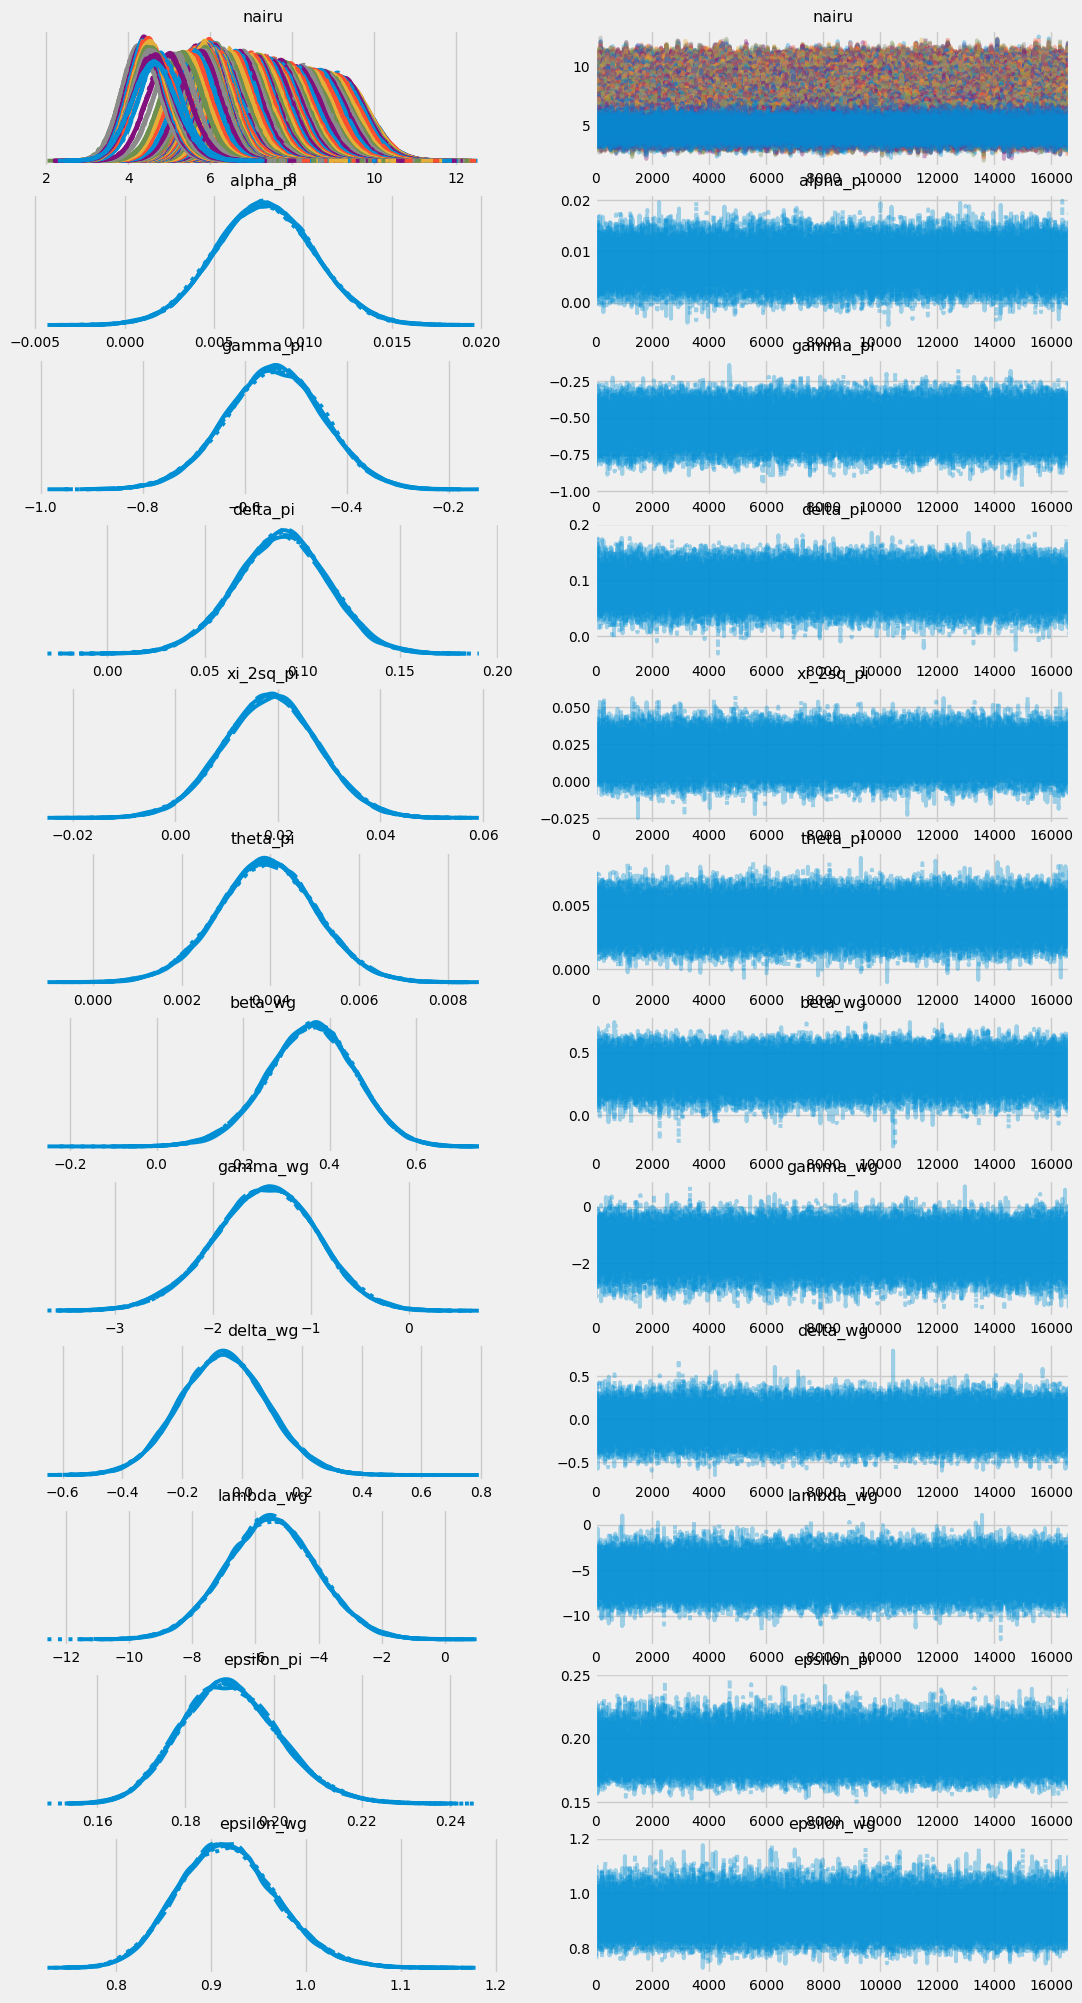

In [19]:
inference_data = fit_the_model(the_model, SAMPLE_ARGS)

## Check diagnostics

In [20]:
def check_inference_data(trace: az.InferenceData) -> None:
    """Check the inference data for potential problems."""

    def warn(w: bool) -> str:
        return "--- THERE BE DRAGONS ---> " if w else ""

    summary = az.summary(trace)

    # check model convergence
    max_r_hat = 1.01  # Best result is 1.0
    statistic = summary.r_hat.max()
    print(
        f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}"
    )

    # check effective sample size
    min_ess = 400  # best if the minimum effective sample size is > 1000
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(
        f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {int(statistic)}"
    )

    # check for divergences in the posterior sampling process
    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))  # type: ignore[attr-defined]
    except (ValueError, AttributeError):  # No sample_stats, or no .diverging
        diverging_count = 0
    print(
        f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}"
    )

    # check the Baesian Fraction of Missing Information
    min_bfmi = 0.3  # Values less than 0.3 indicate poor sampling
    statistic = az.bfmi(trace).min()
    print(
        f"{warn(statistic < min_bfmi)}Minimum Bayesian fraction of missing information: {statistic:0.2f}"
    )


check_inference_data(inference_data)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 24858
Divergent transitions in HMC sampling: 0
Minimum Bayesian fraction of missing information: 0.99


## Results

In [21]:
def get_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

In [22]:
def plot_nairu(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    nairu = get_var("nairu", trace)
    nairu.index = input_index.to_timestamp()
    # cuts = [5, 15, 25, 35, 49]
    cuts = [2.5, 16, 49.5]  # align lower two cuts to standard deviations
    colors = [(p - min(cuts)) / (max(cuts) - min(cuts)) for p in cuts]
    min_color_strength = 0.25
    color_fracs = [c * (1.0 - min_color_strength) + min_color_strength for c in colors]
    palette = "Blues"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(cuts):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]:0.0f}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = color_fracs[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    u = unemployment[unemployment.index >= input_index.min()]
    ax.plot(u.index.to_timestamp(), u, label="_", color="white", lw=3, zorder=9)
    ax.plot(
        u.index.to_timestamp(),
        u,
        label="Unemployment rate",
        color="black",
        lw=1,
        zorder=10,
    )
    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(
        nairu.index[-1],  # type: ignore[arg-type]
        latest,
        f" {latest}",
        va="center",
        ha="left",
        color="black",
        fontsize=8,
    )

    # mark progressive changes to the NAIRU
    # may need to adjust the x-axis labels.
    ymin, _ymax = ax.get_ylim()
    period = pd.Period("1985Q1", freq="Q")
    while period < input_index[-1]:
        index = period.to_timestamp()
        progress = round(nairu.loc[index].quantile(0.5), 1)
        ax.text(
            index,  # type: ignore[arg-type]
            ymin + 0.2,
            f"{progress}",
            va="bottom",
            ha="center",
            color="black",
            fontsize=8,
        )
        period += 20  # 5 years = 20 quarters

    mg.finalise_plot(
        ax,
        title="Estimating the NAIRU",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="Australia. Non-Accelerating Inflation Rate of Unemployment.",
        show=SHOW,
    )


plot_nairu(inference_data, U, obs_index)

In [23]:
def print_parameter_summary(trace: az.InferenceData, model: pm.Model) -> None:
    """Print the summary results of the model,
    useful for non-vector free variables in the model.
    Also indicates where parameters may be indistinguisable from zero,
    (ie. they are not significant within the model).

    Note: It is critical that the gamma priors resolve to non-zero values,
    as they indicate the NAIRU is significant within the model."""

    # Calculate median and Highest Debsity Intervals (HDI) for the model parameters
    q = [0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.98]
    print(f"{(q[-1] - q[0]) * 100:0.0f}% HDI for the univariate model parameters:")
    results = {
        str(name): (
            az.extract(trace, var_names=str(name)).to_dataframe()[str(name)].quantile(q)
        )
        for name in model.free_RVs
        # if str(name) not in ["nairu"]
    }

    # Identify if the HDI includes zero, which is often a sign of a
    # problematic parameter in the regression-like equation.
    # Other than the gamma values, paramaters should have at least a 90%
    # proababikity of not being zero (2 or fewer starts -- see q above).
    # For gamma, I want > 98% probability - i.e. there should be no stars.
    # Note: this is a one-sided significane test.

    df = pd.DataFrame(results).T.sort_index()
    problem_intensity = (
        # how many stars to give: 0,1=great, 2=okay, 3+=parameter not significant
        pd.DataFrame(np.sign(df.T))  # type: ignore
        .apply([lambda x: x.lt(0).sum(), lambda x: x.gt(0).sum()])
        .min()
        .astype(int)
    )
    marker = pd.Series(["*"] * len(problem_intensity), index=problem_intensity.index)
    markers = (
        marker.str.repeat(problem_intensity).reindex(problem_intensity.index).fillna("")
    )
    df["Check Significance"] = markers
    display(df)


print_parameter_summary(inference_data, the_model)

96% HDI for the univariate model parameters:


,0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98,Check Significance
alpha_pi,0.002131,0.003300,0.004305,0.005970,0.007831,0.009716,0.011416,0.012452,0.013582,
beta_wg,0.137195,0.184475,0.224621,0.289192,0.358599,0.425531,0.484767,0.519717,0.558368,
delta_pi,0.039247,0.049366,0.058758,0.073468,0.089553,0.105291,0.119600,0.127914,0.137580,
delta_wg,-0.357939,-0.299164,-0.247560,-0.160959,-0.062389,0.036157,0.126361,0.182432,0.245385,****
epsilon_pi,0.169152,0.172785,0.176286,0.182511,0.189809,0.197594,0.204956,0.209502,0.214996,
epsilon_wg,0.818047,0.836283,0.852529,0.881548,0.915986,0.951671,0.986186,1.007716,1.032927,
gamma_pi,-0.741590,-0.701392,-0.665254,-0.606051,-0.541304,-0.477590,-0.420945,-0.387404,-0.349404,
gamma_wg,-2.591911,-2.353457,-2.144855,-1.813428,-1.456909,-1.109430,-0.812341,-0.632414,-0.432501,
lambda_wg,-8.449447,-7.871366,-7.346634,-6.472250,-5.506485,-4.532992,-3.641152,-3.105627,-2.516071,
nairu,4.168198,4.605750,5.130811,5.798065,6.660639,8.253155,9.120189,9.517150,9.917438,


## Finished

In [24]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-12-01 16:50:35

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.7.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

readabs   : 0.1.7
mgplot    : 0.2.12
arviz     : 0.22.0
typing    : 3.10.0.0
IPython   : 9.7.0
pymc      : 5.26.1
numpy     : 2.3.5
matplotlib: 3.10.7
pandas    : 2.3.3

Watermark: 2.5.0

